# Import necessary library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings("ignore")

import requests
from io import BytesIO

import gzip
import os
import shutil
import pickle
from zipfile import ZipFile
from google.colab import files

# Load the data

In [ ]:
# List of cities and relevant information
cities = [
     ("asheville", "nc", "2023-09-13"),
    ("austin", "tx", "2023-09-10"),
    ("boston", "ma", "2023-09-16"),
    ("bozeman", "mt", "2023-10-08"),
    ("broward-county", "fl", "2023-09-21"),
    ("cambridge", "ma", "2023-09-23"),
    ("chicago", "il", "2023-09-12"),
    ("clark-county-nv", "nv", "2023-09-16"),
    ("columbus", "oh", "2023-09-22"),
    ("dallas", "tx", "2023-09-12"),
    ("denver", "co", "2023-09-24"),
    ("fort-worth", "tx", "2023-09-07"),
    ("hawaii", "hi", "2023-09-10"),
    ("jersey-city", "nj", "2023-09-18"),
    ("los-angeles", "ca", "2023-09-03"),
    ("nashville", "tn", "2023-09-16"),
    ("new-orleans", "la", "2023-09-03"),
    ("new-york-city", "ny", "2023-10-01"),
    ("newark", "nj", "2023-09-25"),
    ("oakland", "ca", "2023-09-18"),
    ("pacific-grove", "ca", "2023-09-25"),
    ("portland", "or", "2023-09-17"),
    ("rhode-island", "ri", "2023-09-25"),
    ("rochester", "ny", "2023-10-23"),
    ("salem-or", "or", "2023-09-18"),
    ("san-diego", "ca", "2023-09-18"),
    ("san-francisco", "ca", "2023-09-02"),
    ("san-mateo-county", "ca", "2023-09-18"),
    ("santa-clara-county", "ca", "2023-09-18"),
    ("santa-cruz-county", "ca", "2023-09-25"),
    ("seattle", "wa", "2023-09-18"),
    ("twin-cities-msa", "mn", "2023-09-17"),
    ("washington-dc", "dc", "2023-09-13")
]

In [ ]:
def download_reviews_data(city, state, date):
    # Full path to data on Inside Airbnb website
    url = f"http://data.insideairbnb.com/united-states/{state}/{city}/{date}/data/reviews.csv.gz"
    response = requests.get(url)

    if response.status_code == 200:
        with gzip.open(BytesIO(response.content)) as file:
            city_reviews_df = pd.read_csv(file, encoding='utf-8')
            return city_reviews_df
    else:
        print(f"Unable to download data for {city}, {state}. Error code: {response.status_code}")
        return None

In [ ]:
city_reviews_df = {f"{city}".replace("-", "_"):
download_reviews_data(city, state, date) for city, state, date in tqdm(cities, desc="Downloading Data")
if download_reviews_data(city, state, date) is not None}

# EDA

## Preprocessing

First, we look at the shape of all the dataframes

In [ ]:
def get_shapes(dfs):
    shapes = {}  # Dictionary to store shapes

    for city, df in dfs.items():
        shapes[city] = df.shape

    return shapes

# Use the function to get the shape for each city
shapes = get_shapes(city_reviews_df)

# Print the shape of each city
for city, shape in shapes.items():
    print(f"Shape of {city}: {shape}")

Shape of asheville: (322620, 6)
Shape of austin: (562390, 6)
Shape of boston: (184680, 6)
Shape of bozeman: (34223, 6)
Shape of broward_county: (507984, 6)
Shape of cambridge: (54870, 6)
Shape of chicago: (397365, 6)
Shape of clark_county_nv: (479007, 6)
Shape of columbus: (125548, 6)
Shape of dallas: (202133, 6)
Shape of denver: (305625, 6)
Shape of fort_worth: (65677, 6)
Shape of hawaii: (1117686, 6)
Shape of jersey_city: (41840, 6)
Shape of los_angeles: (1532925, 6)
Shape of nashville: (593047, 6)
Shape of new_orleans: (441213, 6)
Shape of new_york_city: (983621, 6)
Shape of newark: (43326, 6)
Shape of oakland: (122573, 6)
Shape of pacific_grove: (21603, 6)
Shape of portland: (461928, 6)
Shape of rhode_island: (223795, 6)
Shape of rochester: (37679, 6)
Shape of salem_or: (16260, 6)
Shape of san_diego: (760807, 6)
Shape of san_francisco: (364602, 6)
Shape of san_mateo_county: (186905, 6)
Shape of santa_clara_county: (219068, 6)
Shape of santa_cruz_county: (150914, 6)
Shape of seattle

In [ ]:
city_reviews_df["los_angeles"].info(max_cols = 20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1532925 entries, 0 to 1532924
Data columns (total 6 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   listing_id     1532925 non-null  int64 
 1   id             1532925 non-null  int64 
 2   date           1532925 non-null  object
 3   reviewer_id    1532925 non-null  int64 
 4   reviewer_name  1532925 non-null  object
 5   comments       1532639 non-null  object
dtypes: int64(3), object(3)
memory usage: 70.2+ MB


It seems that the comments column has some null values here, we remove some columns that are not necessary for analysis and then remove null values and duplicates

In [ ]:
def remove_unnecessary_columns(dfs):
    for city, df in dfs.items():
        df.drop(columns=['id', 'date', 'reviewer_id', 'reviewer_name'], inplace=True)
    return dfs

for city, df in city_reviews_df.items():
    city_reviews_df[city] = remove_unnecessary_columns({city: df})[city]

In [ ]:
city_reviews_df['los_angeles'].columns

Index(['listing_id', 'comments'], dtype='object')

Drop null, duplicates comments

In [ ]:
# Check for null values in the "comments" column for each df
def check_null_comments(dfs):
    for city, df in dfs.items():
        null_counts = df['comments'].isnull().value_counts()
        print(f"Number of null values in {city}: {null_counts[True]}")

check_null_comments(city_reviews_df)

Number of null values in asheville: 60
Number of null values in austin: 139
Number of null values in boston: 54
Number of null values in bozeman: 2
Number of null values in broward_county: 174
Number of null values in cambridge: 8
Number of null values in chicago: 98
Number of null values in clark_county_nv: 181
Number of null values in columbus: 41
Number of null values in dallas: 82
Number of null values in denver: 56
Number of null values in fort_worth: 25
Number of null values in hawaii: 195
Number of null values in jersey_city: 8
Number of null values in los_angeles: 286
Number of null values in nashville: 220
Number of null values in new_orleans: 121
Number of null values in new_york_city: 222
Number of null values in newark: 21
Number of null values in oakland: 12
Number of null values in pacific_grove: 6
Number of null values in portland: 55
Number of null values in rhode_island: 41
Number of null values in rochester: 6
Number of null values in salem_or: 1
Number of null values

In [ ]:
# Drop null values in the "comments" column for each df
def drop_null_comments(dfs):
    for city, df in dfs.items():
        df.dropna(subset=["comments"], inplace=True)

drop_null_comments(city_reviews_df)

In [ ]:
city_reviews_df['los_angeles'].isnull().sum()

listing_id    0
comments      0
dtype: int64

In [ ]:
def drop_duplicates(dfs):
    for df_name, df in dfs.items():
        # Drop duplicates based on 'listing_id' and 'comments' columns
        dfs[df_name] = df.drop_duplicates(subset=['listing_id', 'comments'])

    return dfs

city_reviews_df = drop_duplicates(city_reviews_df)

In [ ]:
# Check duplicates for each df
def check_duplicates(dfs):
    for df_name, df in dfs.items():
        duplicates = df.duplicated()
        num_duplicates = duplicates.sum()
        if num_duplicates > 0:
            print(f"Number of duplicates in '{df_name}': {num_duplicates}")
        else:
            print(f"No duplicates found in '{df_name}'")

check_duplicates(city_reviews_df)

No duplicates found in 'asheville'
No duplicates found in 'austin'
No duplicates found in 'boston'
No duplicates found in 'bozeman'
No duplicates found in 'broward_county'
No duplicates found in 'cambridge'
No duplicates found in 'chicago'
No duplicates found in 'clark_county_nv'
No duplicates found in 'columbus'
No duplicates found in 'dallas'
No duplicates found in 'denver'
No duplicates found in 'fort_worth'
No duplicates found in 'hawaii'
No duplicates found in 'jersey_city'
No duplicates found in 'los_angeles'
No duplicates found in 'nashville'
No duplicates found in 'new_orleans'
No duplicates found in 'new_york_city'
No duplicates found in 'newark'
No duplicates found in 'oakland'
No duplicates found in 'pacific_grove'
No duplicates found in 'portland'
No duplicates found in 'rhode_island'
No duplicates found in 'rochester'
No duplicates found in 'salem_or'
No duplicates found in 'san_diego'
No duplicates found in 'san_francisco'
No duplicates found in 'san_mateo_county'
No dupl

In [ ]:
city_reviews_df['los_angeles'].head()

,listing_id,comments
0,8941071,"Danielle was a great host, she was extremely r..."
1,8941071,The apartment was great for us to spend the we...
2,8941071,"Danielle is a great host, very concerned with..."
3,8941071,Great location and spacious. Danielle's place ...
4,8941071,"Danielle's place was as expected, really good ..."


## Reviews analysis

In [ ]:
!pip install vaderSentiment

We use the publicly available pre-trained Vader sentiment model based on NLTK for evaluating the positivity, negativity, and neutrality of a review

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

# Function to calculate sentiment polarity using vaderSentiment
def calculate_polarity(entry):
    # Check if entry is a non-empty string
    if not isinstance(entry, str) or not entry.strip():
        return -2
    # Calculate sentiment scores
    sentiment = analyzer.polarity_scores(entry)

    return sentiment['compound']

Calculating the mean polarity for each listing

In [ ]:
def calculate_mean_polarity(df):
    # Calculate polarity for comments in the city df
    df['polarity'] = df['comments'].apply(calculate_polarity)
    # Remove rows with polarity == -2 (indicating issues with the review)
    df = df[df['polarity'] != -2]
    # Calculate the mean polarity for each listing_id
    mean_polarity = df.groupby('listing_id')['polarity'].mean()
    return mean_polarity

Next, ploting an average polarity histogram for cities showing the frequency of each assessment level

In [ ]:
def plot_polarity_histogram(city_reviews_df):
    num_cities = len(city_reviews_df)
    num_cols = 3 # Set the number of columns in the subplot grid

    # Calculate the number of rows needed
    num_rows = int(np.ceil(num_cities / num_cols))

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Iterate over cities and plot histograms
    for i, (city, df) in enumerate(city_reviews_df.items()):
        mean_polarity = calculate_mean_polarity(df)

        # Determine the subplot index
        subplot_index = i % num_cols + (i // num_cols) * num_cols

        # Plot histogram on the corresponding subplot
        axes[subplot_index].hist(mean_polarity, bins='scott')
        axes[subplot_index].set_title(f'{city}')
        axes[subplot_index].set_xlabel('Average Polarity')
        axes[subplot_index].set_ylabel('Frequency')

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

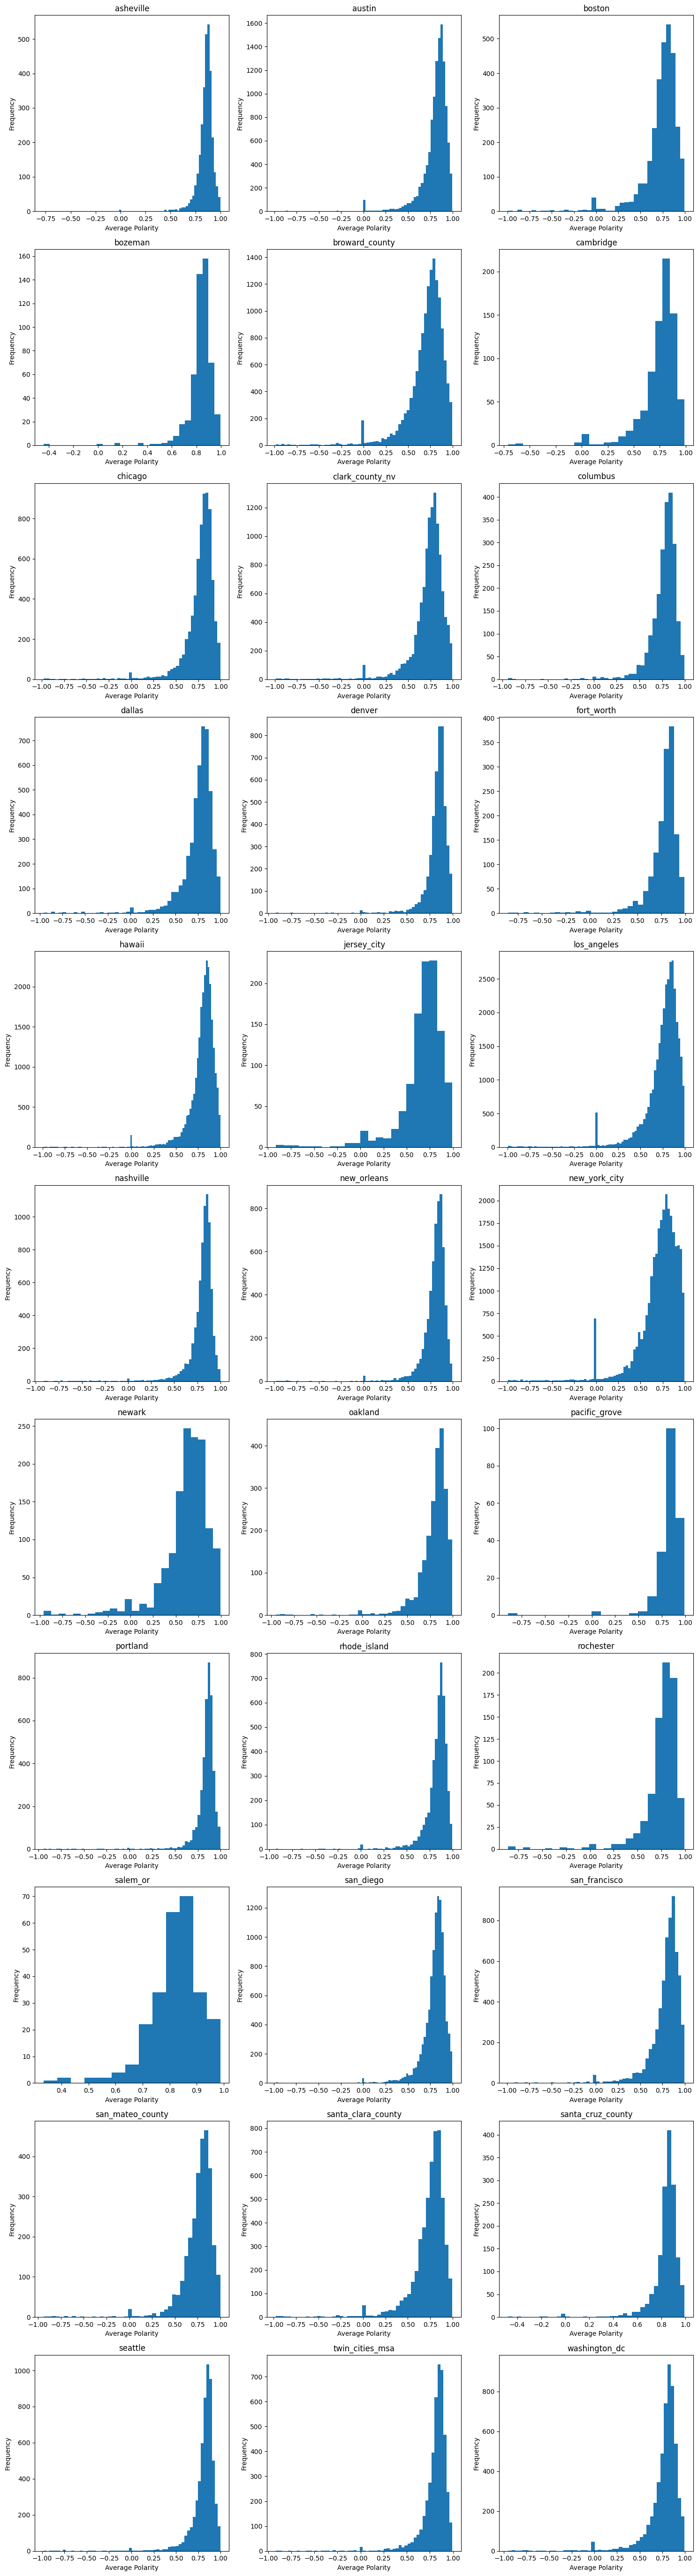

In [ ]:
plot_polarity_histogram(city_reviews_df)

 Calculate the percentage of very negative reviews with polarity < -0.8 for each city

In [ ]:
# Create an empty dictionary to store the ratios
ratios = {}

# Loop through each city's df in city_reviews_df
for city, df in city_reviews_df.items():
    city_ratio = (df['polarity'] < -0.8).mean() * 100
    ratios[city] = city_ratio

# Print the ratio of each city
for city, ratio in ratios.items():
    print(f"{city} ratio: {ratio}%")

asheville ratio: 0.09528598209740896%
austin ratio: 0.22951514924721525%
boston ratio: 0.5248987656465428%
bozeman ratio: 0.13166749568423208%
broward_county ratio: 0.669221721385887%
cambridge ratio: 0.46750305885790466%
chicago ratio: 0.38882819143164976%
clark_county_nv ratio: 0.5572756714208855%
columbus ratio: 0.2764991689042322%
dallas ratio: 0.49593915685378975%
denver ratio: 0.15867655881687612%
fort_worth ratio: 0.3023408511353051%
hawaii ratio: 0.6733660063424076%
jersey_city ratio: 1.333492937514963%
los_angeles ratio: 0.5479734980565372%
nashville ratio: 0.2224491037802825%
new_orleans ratio: 0.37114216447386345%
new_york_city ratio: 0.9558400277114142%
newark ratio: 0.9432204574036984%
oakland ratio: 0.41988661427614493%
pacific_grove ratio: 0.29672214752654275%
portland ratio: 0.144128133161391%
rhode_island ratio: 0.19645662067761868%
rochester ratio: 0.268517041527091%
salem_or ratio: 0.129366106080207%
san_diego ratio: 0.4117166094143144%
san_francisco ratio: 0.6317136

In [ ]:
from collections import Counter

In [ ]:
def show_most_common_duplicates(df, top_number=3):
    '''
    Shows several most common duplicates together with their occurence frequency

    Args:
        df (pandas dataframe): dataframe that contains ['polarity'] column
        top_number (int, default = 3): number of most common duplicates to show

    Returns:
        val_freq_list (list): sorted list that contains the top value and the corresponding frequency

    '''

    res = list(Counter(df.polarity.values).most_common(top_number))
    val_freq_list = [(i[0], i[1]/df.shape[0]) for i in res]
    return val_freq_list

In [ ]:
for city, df in city_reviews_df.items():
    most_common_duplicates = show_most_common_duplicates(df)
    print(f"Most common duplicates in {city}:")
    for value, frequency in most_common_duplicates:
        print(f"Value: {value}, Frequency: {frequency}")
    print("\n")

Most common duplicates in asheville:
Value: 0.6249, Frequency: 0.016071362061901746
Value: 0.6588, Frequency: 0.015627521819558766
Value: 0.0, Frequency: 0.01134741206997157


Most common duplicates in austin:
Value: 0.6249, Frequency: 0.02327226590969434
Value: 0.0, Frequency: 0.019211202049955182
Value: 0.6588, Frequency: 0.019063300206884386


Most common duplicates in boston:
Value: 0.0, Frequency: 0.04299067449762791
Value: 0.6249, Frequency: 0.023536308664357908
Value: 0.6588, Frequency: 0.01617578409127919


Most common duplicates in bozeman:
Value: 0.6249, Frequency: 0.02311496035345408
Value: 0.6588, Frequency: 0.018316411621850954
Value: 0.0, Frequency: 0.014717500073148608


Most common duplicates in broward_county:
Value: 0.0, Frequency: 0.062347545331828194
Value: 0.6249, Frequency: 0.031031678994608333
Value: 0.6588, Frequency: 0.013990306053979808


Most common duplicates in cambridge:
Value: 0.0, Frequency: 0.041143921547142935
Value: 0.6249, Frequency: 0.02240727551635

In [ ]:
city_reviews_df['asheville'][city_reviews_df['asheville'].polarity == 0.0].comments.head(30)

27      As described, it is a cozy basement apartment ...
47      The reservation was canceled 77 days before ar...
105     The reservation was canceled 9 days before arr...
242     The host canceled this reservation 20 days bef...
248     The host canceled this reservation 30 days bef...
257                                                     A
275                              Can't beat the location!
291          Great/cheap place to stay in West Asheville.
324            Exactly what I needed for a one night stay
656     J'ai passé quelques jours bien agréables dans ...
689                   Everything was described correctly!
691     The host canceled this reservation 6 days befo...
692               my ratings sum up the total experience.
789       Excellente auberge de jeunesse! Je recommande!!
797     ¡Me alojaría de nuevo! Y una buena parte de la...
818       Simple, affordable lodging. I would stay again.
847                                          Basic hostel
856           

In [ ]:
city_reviews_df['los_angeles'][city_reviews_df['los_angeles'].polarity == 0.0].comments.head(30)

16     The host canceled this reservation 30 days bef...
43                    If you short on money go for it ..
44                                      Prompt Response.
60                                                  よかった
61                                        房东人很好，很热情好客又大方
62           John是个睿智，待人热情的人。和他相处几天里使我感到非常轻松和愉快。谢谢你john！
87                                                  None
186    I will , in coming to Ling Beach make them my ...
251    2박3일 숙박했는데 너무 좋았어요  <br/>주인분들도 친절하였어요<br/>방도 청...
252            Alcira y José son muy cariñosos y atentos
253    Muy agradecido con la atención en la casa en v...
254                  性价比高，房东很好。还有车库不是很大，紧凑型车可以停，再大就不好停了。
318                                         As described
465    The host canceled this reservation 16 days bef...
467    Chole的家非常棒，干净舒适，还有单独的卫生间，没到之前就给了很多有用信息，到了后给我们详...
468                       美麗的房間，方便的地點，提供Los Angeles美好的住宿
469    位置很棒，出行很方便，晚上停车位有点难找。房间rules要求在洗手间使用化妆品护肤品，预定之...
470    Chloe & Joey家位置很棒，客厅可以看到

In [ ]:
def zero_technical_reviews(df):
    '''
    Returns the fraction of "technical" reviews (staring from "The host canceled" or
    "The reservation was canceled") of zero polarity

    Args:
        df (pandas dataframe): dataframe that contacts columns ['comments'] and ['polarity']

    Returns:
        zero_polarity_fraction (float): fraction of "technical" reviews of zero polarity
    '''

    res1 = df[df.polarity == 0.0].comments.map(lambda s: s.startswith('The host canceled')).sum()
    res2 = df[df.polarity == 0.0].comments.map(lambda s: s.startswith('The reservation was canceled')).sum()
    zero_polarity_fraction = (res1+res2)/df.shape[0]
    return zero_polarity_fraction

In [ ]:
for city, df in city_reviews_df.items():
    zero_technical_fraction = zero_technical_reviews(df)
    print(f"Zero technical reviews fraction in {city}: {zero_technical_fraction:.2%}")

Zero technical reviews fraction in asheville: 0.08%
Zero technical reviews fraction in austin: 0.21%
Zero technical reviews fraction in boston: 0.19%
Zero technical reviews fraction in bozeman: 0.10%
Zero technical reviews fraction in broward_county: 0.14%
Zero technical reviews fraction in cambridge: 0.13%
Zero technical reviews fraction in chicago: 0.14%
Zero technical reviews fraction in clark_county_nv: 0.12%
Zero technical reviews fraction in columbus: 0.05%
Zero technical reviews fraction in dallas: 0.05%
Zero technical reviews fraction in denver: 0.12%
Zero technical reviews fraction in fort_worth: 0.07%
Zero technical reviews fraction in hawaii: 0.21%
Zero technical reviews fraction in jersey_city: 0.15%
Zero technical reviews fraction in los_angeles: 0.25%
Zero technical reviews fraction in nashville: 0.07%
Zero technical reviews fraction in new_orleans: 0.17%
Zero technical reviews fraction in new_york_city: 0.61%
Zero technical reviews fraction in newark: 0.07%
Zero technica

In [ ]:
list(city_reviews_df['los_angeles'][city_reviews_df['los_angeles'].polarity < -0.8].comments.head())

["So terrible and uncomfortable stay.. <br/>small house and host was obsessive about cleanliness.. but the sofa in the room and blanket had stains and they were  so dirty so we never used them and we just used our blanket i brought. so ironic.. We gave up using all stuff of the house because She made us feel uncomfortable to stay keeping requesting  to stay clean. <br/>I don' wanna stay there anymore...",
 '!!!WARNING!!!\r<br/>\r<br/>This apartment has SURVEILLANCE CAMERAS installed\r<br/>\r<br/>BEWARE: the hosts will SPY ON YOU and invade your privacy!\r<br/>\r<br/>I had the audacity to walk over the carpet in my new shoes (my fault, I know) and was THROWN OUT of the apartment with no warning whatsoever - the hosts had been watching me the whole time.\r<br/>\r<br/>They do not tell you this on their profile, but they will be FOLLOWING what you do in the apartment.\r<br/>\r<br/>A very unpleasant invasion of privacy...\r<br/>\r<br/>I know I should not have walked across their carpet in m

In [ ]:
list(city_reviews_df['san_francisco'][city_reviews_df['san_francisco'].polarity > 0.9996].comments)

["This was perhaps the most amazing AirBnB experience I've ever had.  I have used AirBnB several times in several countries and it's usually a good experience, but this was outstanding in so many unexpected ways. First off Adam and Alex are incredibly gracious and wonderful hosts. We came in super late and they made the whole place feel like home.\r<br/>\r<br/>The location is amazing. Seriously, amazing (coming from someone who used to live in SF). It's right next to the park, great restaurants around, lots of place to explore, near several great museums, easy Uber access, lots of public transportation, a farmers market, a food truck hangout, a Whole Foods 1 block away... Amazing.\r<br/>\r<br/>The kitchen is really a Kitchen with a capital K. Every spice, pan, knife, cooking implement you could hope for is there. We used that kitchen everyday and it was a godsend since we were visiting with our daughter. Everything worked perfectly, was beautifully clean and shiny, and just made you wa

In [ ]:
list(city_reviews_df['bozeman'][city_reviews_df['bozeman'].polarity > 0.9993].comments)

["We are avid AirBnBers, so we've seen a lot of places over the years. We love this place SO much we didn't want to leave! We even wanted to add an extra day, and thankfully it was available! If we tell everyone how great it is, we might not be able to book it in the future! :) But for Tess and Ryan's sake, I will explain who wonderful it was.<br/>From the first communication when we booked, even to now, Tess & Ryan were extremely responsive and accommodating. They provided us with bikes/helmets and even brought us a coffee pot on our first night when my husband was being too picky to use the Keurig. :) I personally loved having the Keurig and all the amazing k-cup choices which they provide.<br/>The home is incredibly clean and basically straight out of Pinterest. I LOVE the decor and the simplicity of the entire space. TONS of excellent books too. It was convenient to have access to the garage and such a bonus to have a private backyard space (hammock included!). <br/>The backyard wa

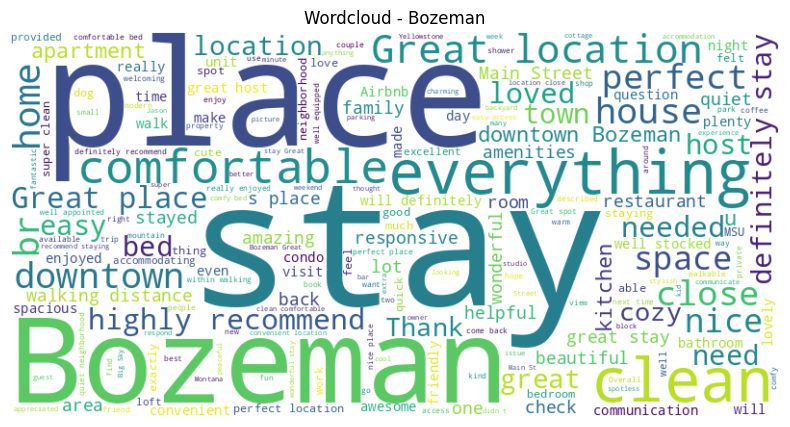

In [ ]:
from wordcloud import WordCloud

# Lấy dữ liệu văn bản từ DataFrame 'los_angeles' trong 'city_reviews_df'
text = ' '.join(city_reviews_df['bozeman']['comments'])

# Khởi tạo WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Hiển thị wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud - Bozeman')
plt.show()

# Preparing data for sentiment classification


With the goal to classify the sentiment for each comment, we perform a clean text job and save it as a pickle file to then apply the above classification pre-trained model to this job.

In [ ]:
for df in city_reviews_df.values():
    df.drop('polarity', axis=1, inplace=True)

## Text preprocessing

In [ ]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199774 sha256=ac6356b394da3a366d60b91f1ae5859107b42b0900c3c4d7140c3d96217a0627
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [ ]:
import fasttext

# Create a language model by fasttext
model = fasttext.load_model('lid.176.bin')

# Check the language of each comment
def is_english(text):
    try:
        prediction = model.predict(text)
        return prediction[0][0] == '__label__en'
    except:
        return False

# Filter and keep only English comments
for city, df in city_reviews_df.items():
    df['is_english'] = df['comments'].apply(is_english)
    city_reviews_df[city] = df[df['is_english']][['listing_id', 'comments']]

In [ ]:
Con_appos = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will"
}

In [ ]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.5/397.5 kB 3.1 MB/s eta 0:00:00


In [ ]:
import re
import nltk
import emoji
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def clean_text(text):
    # Ensure the input text is a string
    text = str(text)

    # Convert to lowercase
    text = text.lower()

    # Change abbreviated words into full words
    pattern = re.compile(r'\b(' + r'|'.join(Con_appos.keys()) + r')\b')
    text = pattern.sub(lambda x: Con_appos[x.group()], text)

    # Preserve the word "not" and "good"
    text = re.sub(r'\bnot\b', 'not_', text)
    text = re.sub(r'\bgood\b', 'good_', text)

    # Remove punctuations and single characters
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\b\w{1}\b', '', text)

    # Remove emojis
    text = emoji.demojize(text)

    # Remove multiple spaces and additional characters
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[_;\\-]', ' ', text)

    # Remove stopwords
    stopwords_list = set(stopwords.words('english')) - {'not'}
    pattern = re.compile(r'\b(' + r'|'.join(stopwords_list) + r')\b\s*')
    text = pattern.sub('', text)

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text))

    return text

In [ ]:
# Apply clean_text for each comment in df of city_reviews_fd
for city, df in tqdm(city_reviews_df.items(), desc="Cleaning DataFrames"):
    df["comments"] = df["comments"].apply(clean_text)

Cleaning DataFrames:  52%|█████▏    | 17/33 [1:55:26<2:41:26, 605.43s/it]

In [ ]:
city_reviews_df['los_angeles']

## Save cleaned dataframes in pickle file

In [ ]:
# Specify the output folder for cleaned DataFrames
output_folder = "cleaned_dataframes"
os.makedirs(output_folder, exist_ok=True)

# Loop through each city DataFrame in city_reviews_df
for city, df in tqdm(city_reviews_df.items(), desc="Saving Cleaned DataFrames"):
    # Save the cleaned DataFrame to a pickle file in the output folder
    output_filename = os.path.join(output_folder, f"cleaned_df_{city}.pkl")
    df.to_pickle(output_filename)

In [ ]:
# Path to the directory containing the pickle files
pickle_folder = "cleaned_dataframes"

# Create file zip store pickle directory
shutil.make_archive(pickle_folder, 'zip', pickle_folder)

# Save file zip
files.download(f'{pickle_folder}.zip')